# Recommender Systems  
<br>
Have you ever wondered how Youtube,Spotify,Amazon,Netflix.... know exactly what you want(well,almost)!? 
Well now you do! 
<br>
Wikipedia defines recommender systems as _A recommender system or a recommendation system (sometimes replacing "system" with a synonym such as platform or engine) is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item._
<br>

Recommender systems have become extremely popular in the recent years and found uses in a variety of fields ranging from movie recommendations all the way to online dating.

In this tutorial we will be looking at two types of recommender systems based on the type of filtering:<br>
> 1. **Content-based filtering** : These type of recommender systems measure the similarity of items and suggest users with items which are similar to what the user has liked previously. For example, consider a recommender system which uses the storyline of a movie, the directors and actors of movies to measure how similar one movie is to another. Based off this model and user's preference history, it suggests movies similar to the user's liking.<br>

> 2. **Collaborative filtering** : Collaborative filtering, as the name suggests, uses information not of the content of the item but rather information of the similar users, their behaviour and preferences to produce recommendations. In contrast to our previous movie recommendation example, in collaborative filtering, we would use review data that users have given for various movies to build a profile of users who have rated movies similarly. This similarity of users is what we can say is the **inductive bias** of a collaborative filtering model i.e. in the absence of complete information about a user, our model prefers to suggest items that other **similar users** have endorsed.

Inductive bias can be thought of as what sort of choice/conclusion our model arrives at in the presence of incomplete data about the task at hand.

** What do you think is the inductive bias of a content-based filtering recommender system? **

# Content-based video game recommender

Let's try to build a video game recommemder using our content-based model. <br>
Note: For the purposes of this tutorial we will be considering only those games that can be played on a Windows PC
### Getting the data
The first step is to find a dataset of all PC games. __[IGDB](https://www.igdb.com/discover)__ is a good source that has a large database of games played over a variety of platforms and we will be using their Developer API to extract game data.

In addition to the API, we will also be using their python wrappers. More information on the python wrapper can be found at __[IGDB-python wrapper](https://github.com/igdb/igdb_api_python)__

In [1]:
from IPython.display import Image
from IPython.display import display
import pandas as pd
import csv
import requests
import numpy as np
from igdb_api_python.igdb import igdb

igdb = igdb("YOUR API KEY HERE")

In [ ]:
result = igdb.platforms(6)    # 6 - platform ID for Windows PC 
for platform in result.body:
    pc_games = platform['games']

# Uncomment the below code if you want to write all pc_game indicies into a file
# with open("pc_games.txt","w") as f:
#     for game in pc_games:
#         f.write(str(game)+"\n")
        
with open("all_games.tsv","w") as o:
    writer = csv.writer(o,delimiter="\t",quoting = csv.QUOTE_NONE,escapechar='\\')
    game = pc_games[0]
    fields= ['id','name','summary','storyline','cover']
    writer.writerow(fields)
    pc_games = list(map(int,pc_games))
    print(len(pc_games))
    start = 0
    offset = 1000
    end = start+offset
    while end < len(pc_games):
        game_info = igdb.games({
            'ids':pc_games[start:end],
            'fields': fields
        })
        for info in game_info.body:
            row = []
            for field in fields:
                if field in info:
                    if field == 'storyline'or field == "summary":
                        info[field] = info[field].replace("\n","")
                        info[field] = info[field].replace("\t","")
                        info[field] = info[field].replace("\r","")
                        row.append(info[field])
                    elif field == 'cover':
                        row.append(info[field]['url'])
                    else:
                        row.append(info[field])

                else:
                    row.append('NaN')
            writer.writerow(row)
        start = end
        end = start + offset

### Building the recommender

In [2]:
import pandas as pd

game_df = pd.read_csv("all_games.tsv",delimiter="\t")
game_df.head()

,id,name,summary,storyline,cover
0,1059,Kingdoms of Amalur: Reckoning,"Kingdoms of Amalur: Reckoning is an epic, open...","Forge your own destiny. You have been reborn, ...",//images.igdb.com/igdb/image/upload/t_thumb/wb...
1,3011,Harry Potter and the Order of the Phoenix,Harry Potter and the Order of the Phoenix is a...,NaN,//images.igdb.com/igdb/image/upload/t_thumb/ah...
2,1274,SimCity,This is a new SimCity that delivers unpreceden...,NaN,//images.igdb.com/igdb/image/upload/t_thumb/cs...
3,750,Homeworld 2,Homeworld 2 is the third game in the Homeworld...,NaN,//images.igdb.com/igdb/image/upload/t_thumb/ce...
4,993,Silent Hunter 4: Wolves of the Pacific,"Hunt, hide and kill as you take command of U.S...",NaN,//images.igdb.com/igdb/image/upload/t_thumb/up...


Now that we have the data, let begin building our recommender.
We will use the "summary" and "storyline" as "content" for each of our games.
Quickly, we realise using the summary and storyline in their current form, as sentences and paragraphs is not going to work well. We are going to need to use TF-IDF vectors or word embeddings of the input in order to process the items.

TF-IDF stands for Term Frequency-Inverse Document Frequency which basically counts the number of times a word occurs in a sentence and then scales the frequency inversely according to the number of documents in which the word occurs. The intuition behind this is to downweigh words that are very common across multiple documents by assuming such words are not very informative. 

We will use scikit-learn library's implementation of TF-IDF vectorizer.

In [3]:
#Import TF-IDF vectorizer from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#Instantiate a tfidf object, which also removes English stop words
tfidf = TfidfVectorizer(stop_words='english')

#Fill NaN values with empty string
game_df = game_df.fillna('')

#Remove spaces in the title of the game and covert it to lowercase just to ease comparisons later on 
def preprocess_titles(title):
    title = title.replace(" ","")
    title = title.lower()
    return title

game_df['name'] = game_df['name'].apply(preprocess_titles)
# game_df.head()

Lets create a column in our dataframe which combines both summary and storyline columns

In [4]:
game_df['soup'] = game_df["summary"] + game_df["storyline"]

#Construct TF-IDF matrix using the 'soup' feature
tf_idf_matrix = tfidf.fit_transform(game_df['soup'])
print(tf_idf_matrix.shape)

(24953, 53875)


The matrix suggests we have 53875 unique words used in the dataset across the 24953 games.

Armed with our TF-IDF matrix we are now ready to compute similarity scores between each pair of documents(here,games).
We will use the concept of Cosine similarity in this tutorial but there are other measures of similarity like the simple Eucledian distance, Pearson Correlation co-efficient, Manhanttan distance etc. which can be used. The choice of similarity measure to use comes down to understanding our dataset and thinking through which measure makes most sense, along with a bit of trial and error. :)

We are going to be using the cosine_similarity function of sklearn for this as well.

In [5]:
#Import cosine similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity_matrix = cosine_similarity(tf_idf_matrix,tf_idf_matrix)

### Interpreting the cosine similarity matrix

-  Each row represents a particular game.
-  Each value in the row represents the pairwise similarity of the game in consideration with the i-th game.

### Predicting similar games

We are finally ready to recommend similar games. Let's create a function that returns recommendations of similar games given the title of a game.

The function locates the corresponding row of the given game title in the cosine similarity matrix and returns the top-k most similar games.

In [6]:
game_titles = game_df['name']
#         print(game_titles)
    #Need a way to map index of the game in the dataframe to its title and vice-versa
title_to_index_map = {t:index for index,t in enumerate(game_titles)}
index_to_title_map = {index:t for index,t in enumerate(game_titles)}
def recommendations(title,cosine_similarity_matrix,k=10):
        title = preprocess_titles(title)
        k += 1
#         game_titles = game_df['name']
# #         print(game_titles)
#         #Need a way to map index of the game in the dataframe to its title and vice-versa
#         title_to_index_map = {t:index for index,t in enumerate(game_titles)}
#         index_to_title_map = {index:t for index,t in enumerate(game_titles)}
        
        #Get row corresponsing to given game 
        game_row = title_to_index_map[title]
        
        #Pairwise cosine similarities between given game and other games
        similarity_scores = cosine_similarity_matrix[game_row]
        
        #Get top-k similar games
        scores = [(score,index) for index,score in enumerate(similarity_scores)]
        topk = sorted(scores,key = lambda x:x[0],reverse=True)[:k]
        
        topk_titles = [index_to_title_map[k[1]] for k in topk]
        return topk_titles
def print_recommendations(recommends):
    for i,recommendation in enumerate(recommends[1:]):
        print(i+1,recommendation)

## Results

Let's put our recommender to the test and see how it performs! 

1 homeworld:remasteredcollection
2 homeworld:emergence
3 homeworld
4 homeworld:desertsofkharak
5 thecolonists
6 sentinel3:homeworld
7 attackoftheearthlings
8 titanattacks!
9 stateofanarchy:masterofmayhem
10 tailwind:prologue


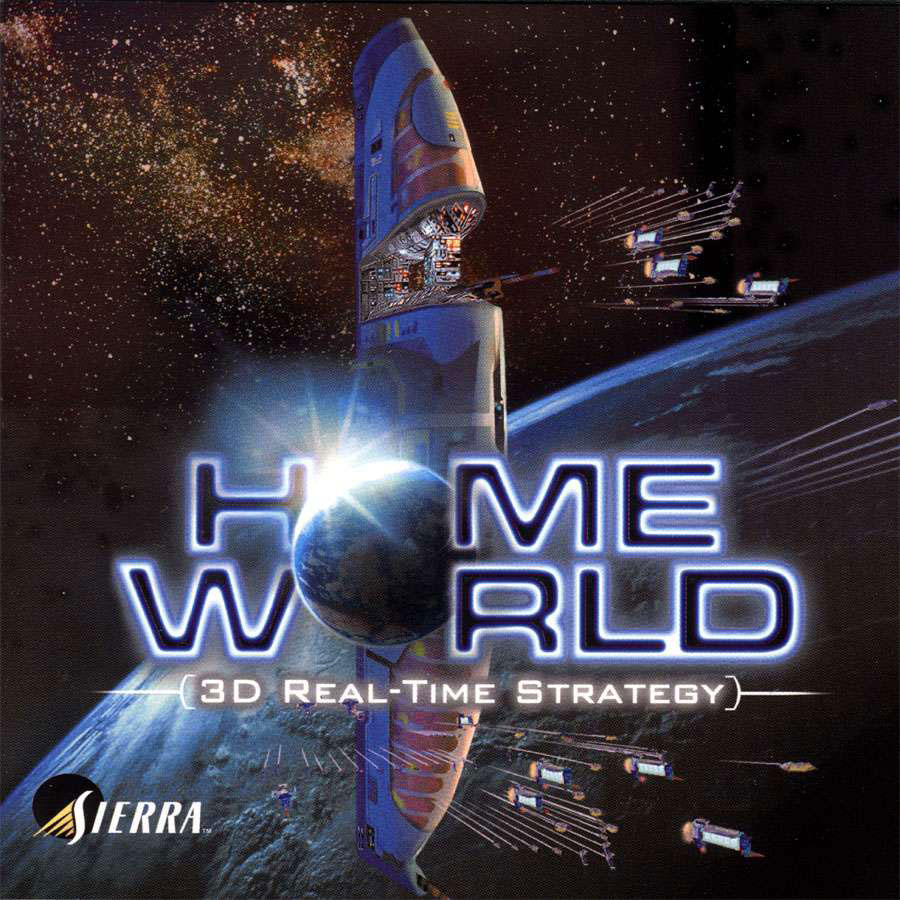

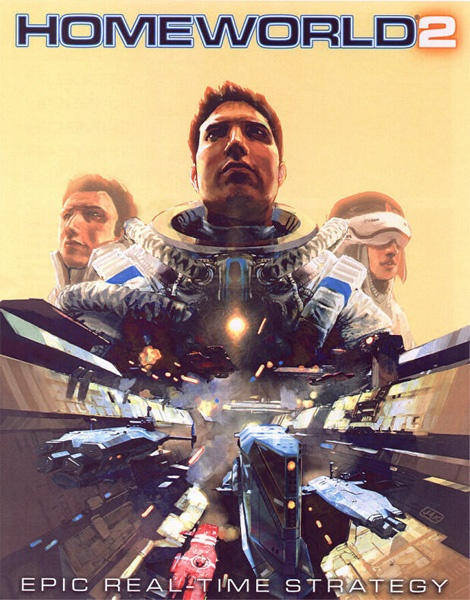

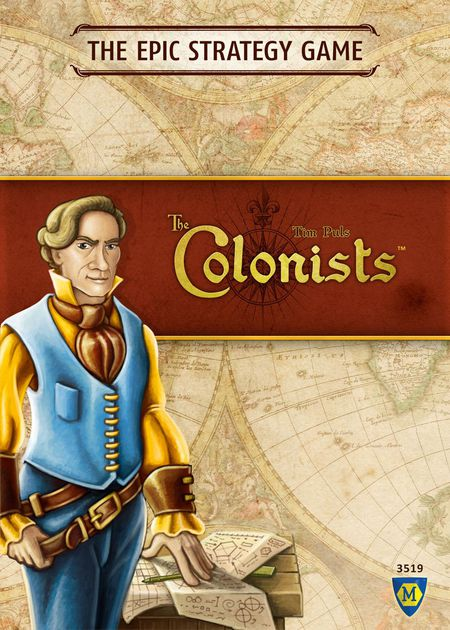

In [7]:
homeworld_recommendations = recommendations("Homeworld 2",cosine_similarity_matrix)
print_recommendations(homeworld_recommendations)
display(Image("homeworld.jpg",width=200,height=200))
display(Image("homeworld2.jpg",width=200,height=200))
display(Image("colonists.jpg",width=200,height=200))

1 simcity:limitededition
2 simcity4deluxeedition
3 simcopter
4 simcity3000unlimited
5 simcity3000
6 simcitysocieties
7 simcity
8 simfarm
9 streetsofsimcity
10 simcitysocieties:destinations
11 simtown
12 simcity4
13 balancity
14 simcity4rushhour
15 kingdomsandcastles


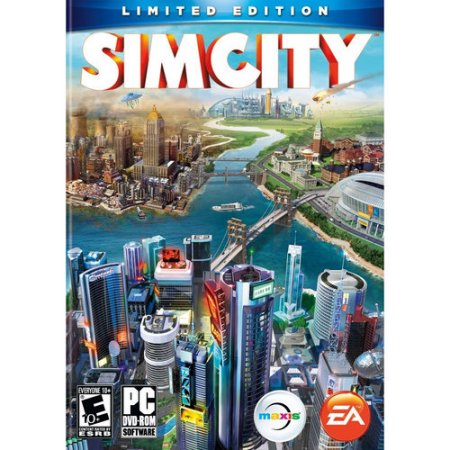

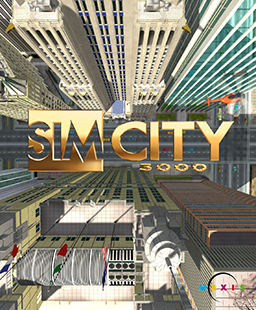

In [8]:
simcity_recommendations = recommendations("SimCity",cosine_similarity_matrix,15)
print_recommendations(simcity_recommendations)
display(Image("simlim.jpeg",width=200,height=200))
display(Image("sim3000.png",width=200,height=200))

1 madagascar:escape2africa
2 harrypotterandthechamberofsecrets
3 residentevil7:biohazard
4 harrypotterandtheprisonerofazkaban
5 fifa14
6 harrypotter:quidditchworldcup
7 juiced2:hotimportnights
8 nba2k10
9 conflict:vietnam
10 nbalive08


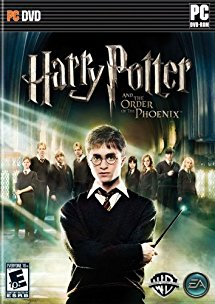

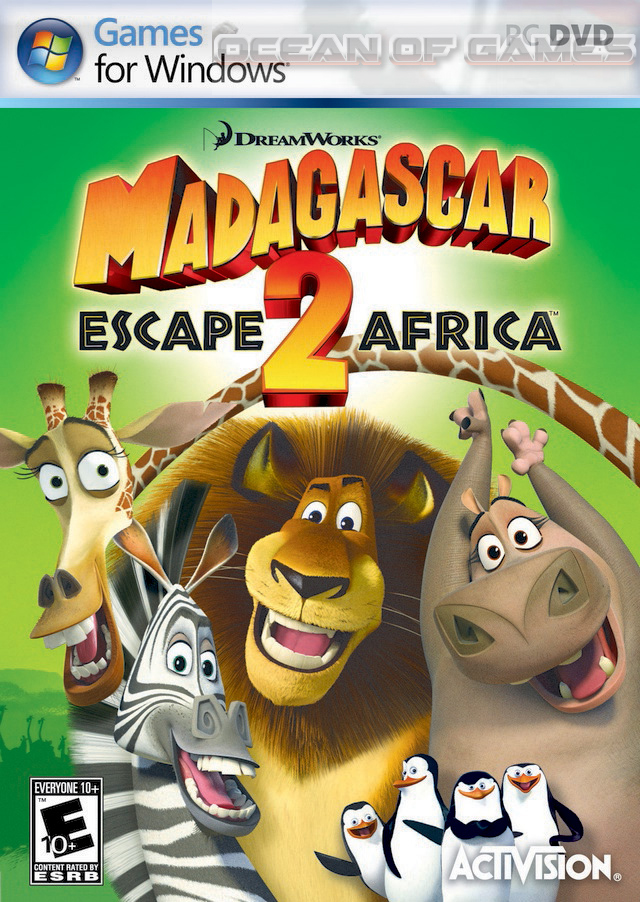

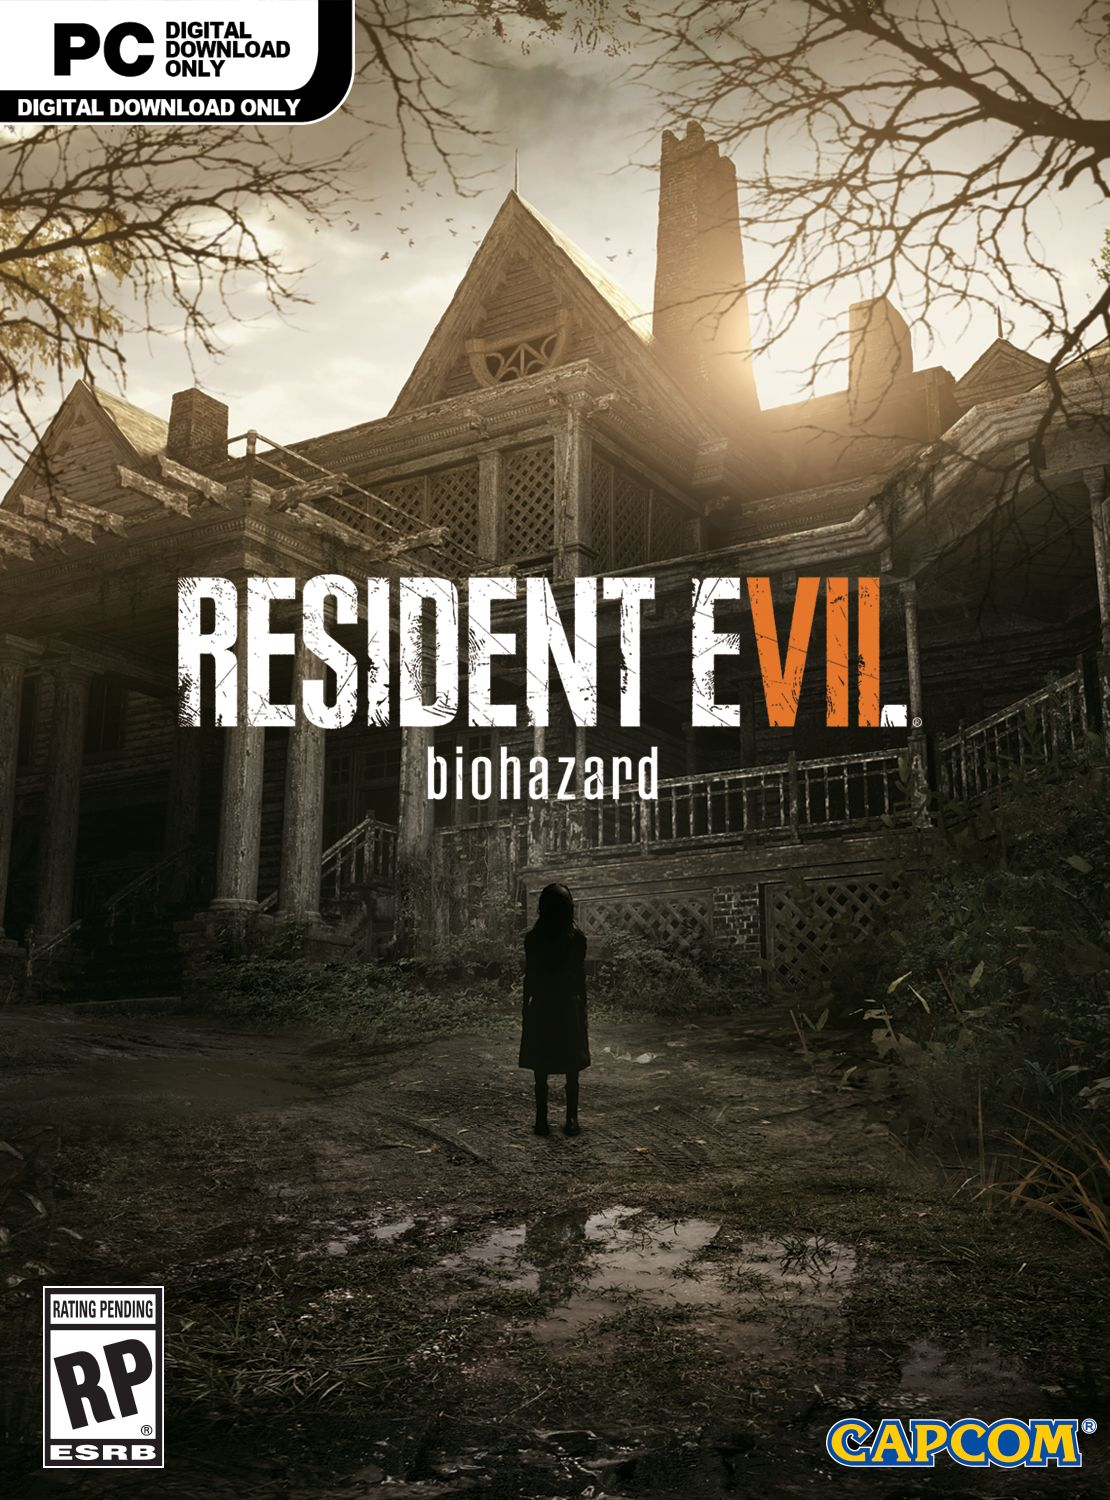

In [9]:
harry_potter_recommendations = recommendations("Harry Potter and the Order of the Phoenix",cosine_similarity_matrix)
print_recommendations(harry_potter_recommendations)
display(Image("hp1.jpg",width=200,height=200))
display(Image("mad.jpg",width=200,height=200))
display(Image("residentevil.jpg",width=200,height=200))

As you can see, the recommender does quite a good job of recommending similar games!

## Improving recommendations 
    
Although the results of the recommender are promising, we can notice a bias in the results. Games with very similar storylines need not be the best recommendation to a user. We need to be able to recommend games with a similar experience but differing storylines. In order to do so, we need to include more features into our current recommender model. We need to use information about 
    -  the developers of the game(EA,Blizzard...) 
    -  the genre of the game(Fantasy,Sci-fi,puzzle...) 
    -  player perspective(First person Shooter, RPG, OpenWorld...)
    and so on and so forth!
    
The more features we have, the better we can make our recommender and more diverse our recommendations.

Other possible considerations to improve recommender:
    -  Using a better similarity measure.
    -  Using only statistically significant features and avoiding irrelevant features.
    and many more! Experimenting with various techniques is the best way to find out what works and what doesn't!
    

# Collaborative filtering

A recommender based on collaborative filtering as stated before is used to recommend items to a user based on the interests on similer users. For this purpose, the dataset we created before will not be appropriate and so we start off from square one - **getting the data!**

We'll use the same API to extract reviews about games.

In [ ]:
#The file we write the data to
with open("reviews.csv","w") as out:
    out.write("id,username,rating,gameID\n")
    #offset is used for pagination purposes
    for offset in range(0,1100,50):
        res = igdb.reviews({
            #fields we are interested in
            'fields' : ['id','username','rating_category','game'],
            'limit' : 50,
            'offset': offset
        })
        
        for info in res.body:
#             print(info['name'])
            if 'rating_category' in info and info['username']!='username':
                out.write(str(info["id"])+","+info['username']+","+str(info['rating_category'])+","+str(info['game'])+"\n")

In [11]:
#Read in the reeview file
reviews_df = pd.read_csv("reviews.csv")

#Drop ID column as its not useful
reviews_df.drop('id',axis=1,inplace=True)

#Get all unique usernames
usernames = reviews_df['username'].unique()

#Map usernames to ID and viceversa
user_to_id = {name:idx for idx,name in enumerate(usernames)}
id_to_user = {idx:name for idx,name in enumerate(usernames)}

#The below functions are used for applying the mapping to the dataframe
def map_users_to_id(user):
    return user_to_id[user]
def map_id_to_users(id):
    return id_to_user(id)

#Similarly map gameID to new IDs we need
games = reviews_df['gameID'].unique()
game_to_id = {name:idx for idx,name in enumerate(games)}
id_to_game = {idx:name for idx,name in enumerate(games)}
def map_game_to_id(game):
    return game_to_id[game]
def map_id_to_game(id):
    return id_to_game(id)

#Apply mapping functions to the dataframe
reviews_df['username'] = reviews_df['username'].apply(map_users_to_id)
reviews_df['game'] = reviews_df['gameID'].apply(map_game_to_id)

print("Number of unique users :", len(usernames))
print("Number of unique games : ", len(games))
print(reviews_df.shape)
reviews_df.head()

Number of unique users : 405
Number of unique games :  786
(1051, 4)


,username,rating,gameID,game
0,0,2,2350,0
1,0,3,2679,1
2,0,3,2324,2
3,1,2,1879,3
4,2,3,1030,4


Let's begin building the model by creating our user/rating matrix. A user/rating matrix is a matrix where each row corresponds to user and the columns consist of the rating for each game in the dataset given by the same user.

With a rather short data set of 1051 records, you can observe the disparity between the number of users and games in the dataset. This is very common in practice as the a user generally is able to rate a small subset of all existing games(items). Constructing a matrix of user/ratings would turn out to be very sparse and this sparsity can be taken advantage of to speed up operations. 
In this tutorial however, we will use dense matrices.

In [12]:
num_users = len(usernames)
num_games = len(games)

#Create ratings matrix of size num_users X num_games 
ratings = np.zeros(shape=(num_users,num_games))

#Fill in the ratings matrix
for id,review in reviews_df.iterrows():
#     print(review)
    ratings[review[0]][review[3]] = review[1]

As with the content-based filtering, we need a measure of similarity like the cosine similarity. Let's create a cosine similarity matrix as before. Here, the cosine similarity matrix is a measure of how similar each pair of users are.

In [13]:
rating_similarity_matrix = cosine_similarity(ratings,ratings)
rating_similarity_matrix.shape

(405, 405)

Now would be a good point to introduce the two types of collaborative filtering:
    -  User-based collaborative filtering : In this type of collaborative filtering, we predict a user's rating for an item(here,game) which is given by the weighted sum of all the other users's rating for the same item.
    -  Item-based collaborative filtering : In this type of collaborative filtering, we predict a user's rating for an item(here,game) based on how the same user has rated items similar to the item in consideration.
    
We will be building a user based collaborative filtering in this tutorial.

Now, to produce predictions for a user's ratings for items unrated by the user, all we need to do is take a dot product between the similarity matrix and the rating matrix and normalize the rows.

In [14]:
pred = rating_similarity_matrix.dot(ratings)

'''
Breaking the below line of code into what exactly each part does(going inner to outer):
    a) np.abs(rating_similarity_matrix) -> gets absolute value of each element in the array
    b) np.abs(rating_similarity_matrix).sum(axis=1) -> sum along the row for each user, as we need to normalize ratings for each user
    c) np.array([np.abs(rating_similarity_matrix).sum(axis=1)]).T -> This part is required to turn a one-dimensional array into a two dimensional one
'''
normalizing_factor = np.array([np.abs(rating_similarity_matrix).sum(axis=1)]).T
user_rating_predictions = pred / normalizing_factor
user_rating_predictions

array([[0.81531098, 1.06150513, 1.06150513, ..., 0.        , 0.        ,
        0.        ],
       [0.027565  , 0.0413475 , 0.0413475 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Results
As a final step, let's calcualte the mean squared error of our prediction from the actual data we have.

In [15]:
pred = user_rating_predictions[ratings.nonzero()].flatten()
actual = ratings[ratings.nonzero()].flatten()
squared_error = np.power((pred-actual),2)
mse = np.sum(squared_error)/len(pred)

print("MSE of user-based collaborative filtering recommender = ",mse)

MSE of user-based collaborative filtering recommender =  0.8448854829336633


## Improving the collaborative filtering recommender system:
    
The model we implemented is a very basic one and there are are simple modifications we can make in order to improve our performance. A few are listen below:
>  -  K-Nearest Neighbours - Consider the ratings of the top-k similar users.
>  -  Bias-subtracted Collaborative filtering - This is to take into account the bias certain users have in their rating pattern. For instance, we need to accomodate for users who generally rate very low or very high. The amount of information these users contribute as a result is low and an appropriate weightage must be assigned to them.
>  -  Using emsemble methods - __[The Netflix Prize](https://www.netflixprize.com/)__ engendered a lot of excitement for receommendation problem and was the impetus for a lot of the breakthrough improvements in the field.
>  -  Recommender systems are very tricky to get just right and a real thorough understanding of the data and user behaviour must be kept in mind while designing the model.

For more information on these topics please refer to links 1. and 2. in the references section. They delve into the indepth implementation of more complex models for the above introduced concepts.

# References

1.  __[Intro to Recommender Systems: Collaborative Filtering](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)__
2.  __[Recommender Systems in Python: Beginner Tutorial](https://www.datacamp.com/community/tutorials/recommender-systems-python)__
3.  __[Wikipedia](https://en.wikipedia.org/wiki/Recommender_system)__
4.  __[IGDB](https://www.igdb.com/discover)__

